In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
%matplotlib inline

In [185]:
df = pd.read_csv('PJME_hourly.csv')

In [186]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [187]:
df.set_index('Datetime', inplace=True)
df.index = pd.to_datetime(df.index)

<AxesSubplot:title={'center':'Estimated Energy Consumption in Megawatts (MW)'}, xlabel='Datetime'>

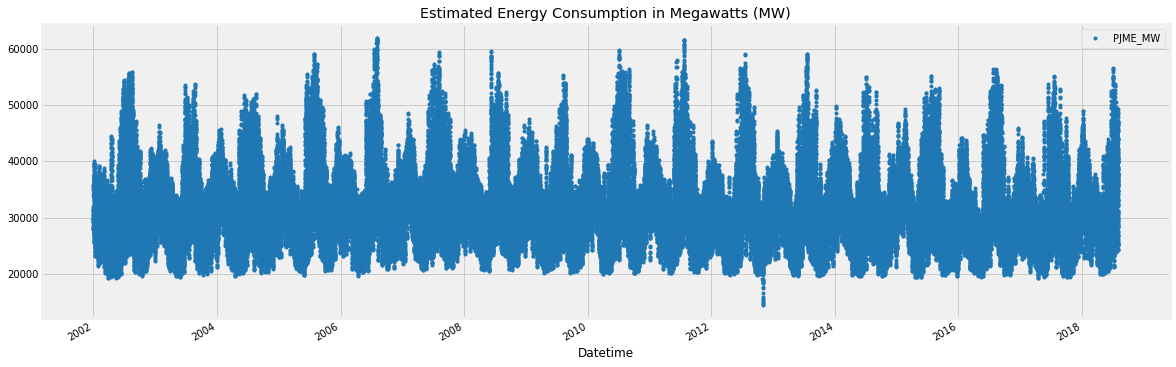

In [188]:
df.plot(style='.', figsize=(18,6), color=color_pal[0], title='Estimated Energy Consumption in Megawatts (MW)')

In [189]:
week_df = df.loc[(df.index > '2015-01-01') & (df.index < '2015-01-08')]

<AxesSubplot:title={'center':'Estimated Energy Consumption in Megawatts (MW)'}, xlabel='Datetime'>

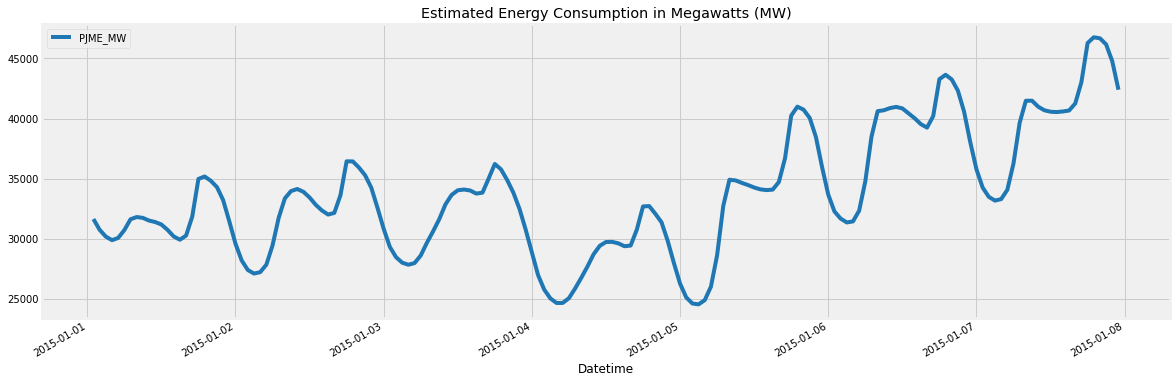

In [190]:
week_df.plot(style='-', figsize=(18,6), color=color_pal[0], title='Estimated Energy Consumption in Megawatts (MW)')

In [191]:
df['hour'] = df.index.hour
df['dayofweek'] = df.index.day_of_week
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.day_of_year
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week

In [192]:
df.tail()

,PJME_MW,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear
Datetime,,,,,,,,
2018-01-01 20:00:00,44284.0,20,0,1,2018,1,1,1
2018-01-01 21:00:00,43751.0,21,0,1,2018,1,1,1
2018-01-01 22:00:00,42402.0,22,0,1,2018,1,1,1
2018-01-01 23:00:00,40164.0,23,0,1,2018,1,1,1
2018-01-02 00:00:00,38608.0,0,1,1,2018,2,2,1


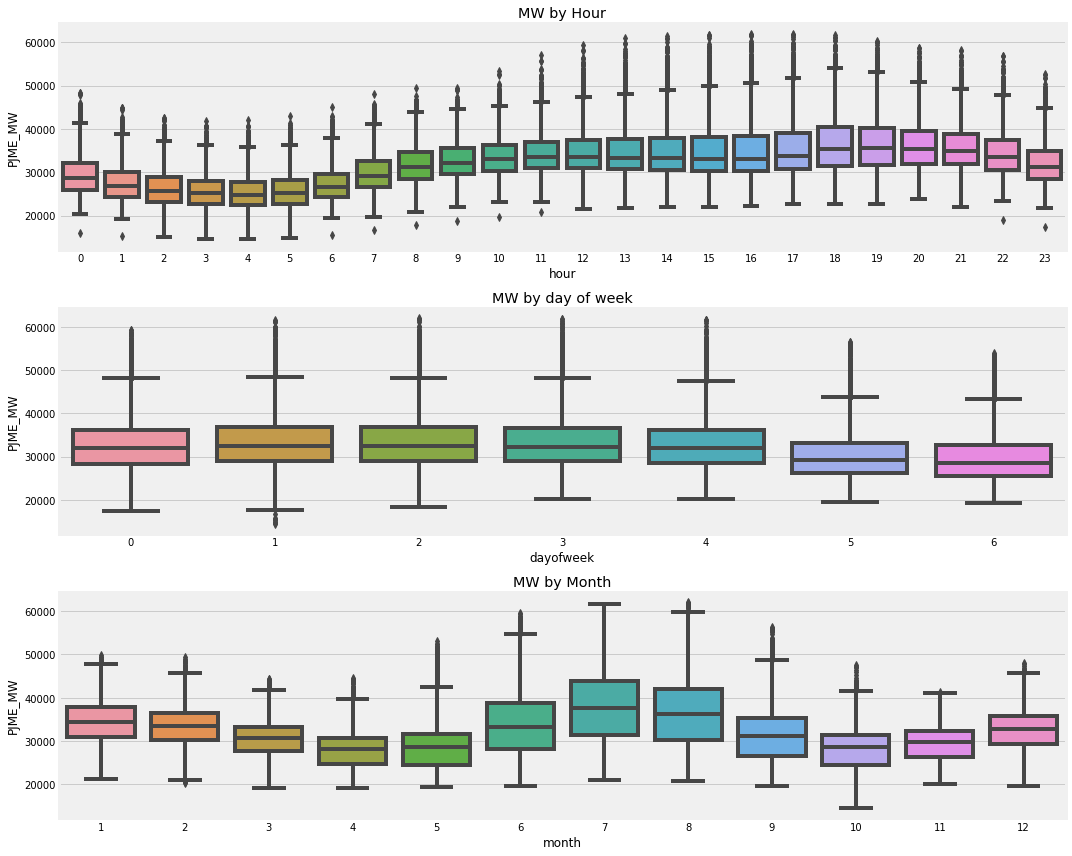

In [193]:
fig, ax = plt.subplots(3,1,figsize=(15,12))
sns.boxplot(data=df, x='hour', y='PJME_MW', ax=ax[0])
ax[0].set_title('MW by Hour')
sns.boxplot(data=df, x='dayofweek', y='PJME_MW', ax=ax[1])
ax[1].set_title('MW by day of week')
sns.boxplot(data=df, x='month', y='PJME_MW', ax=ax[2])
ax[2].set_title('MW by Month')
fig.tight_layout()
plt.show()

In [194]:
#outlier
df = df[df['PJME_MW']>19000].copy()

In [195]:
map_dict = df['PJME_MW'].to_dict()
df['lag_year1'] = (df.index - pd.Timedelta('364 days')).map(map_dict)
df['lag_year2'] = (df.index - pd.Timedelta('728 days')).map(map_dict)
df['lag_week1'] = (df.index - pd.Timedelta('7 days')).map(map_dict)
df['lag_week2'] = (df.index - pd.Timedelta('14 days')).map(map_dict)
df['lag_week3'] = (df.index - pd.Timedelta('21 days')).map(map_dict)
df['lag_week4'] = (df.index - pd.Timedelta('28 days')).map(map_dict)

In [196]:
df = df.dropna()

In [197]:
for i in df.columns:
    df[i] = df[i].astype(float)

In [198]:
from sklearn.model_selection import TimeSeriesSplit

In [199]:
tes = TimeSeriesSplit(n_splits=5, test_size=24*365*1)
df = df.sort_index()

In [200]:
tes.split(df)

<generator object TimeSeriesSplit.split at 0x29befa040>

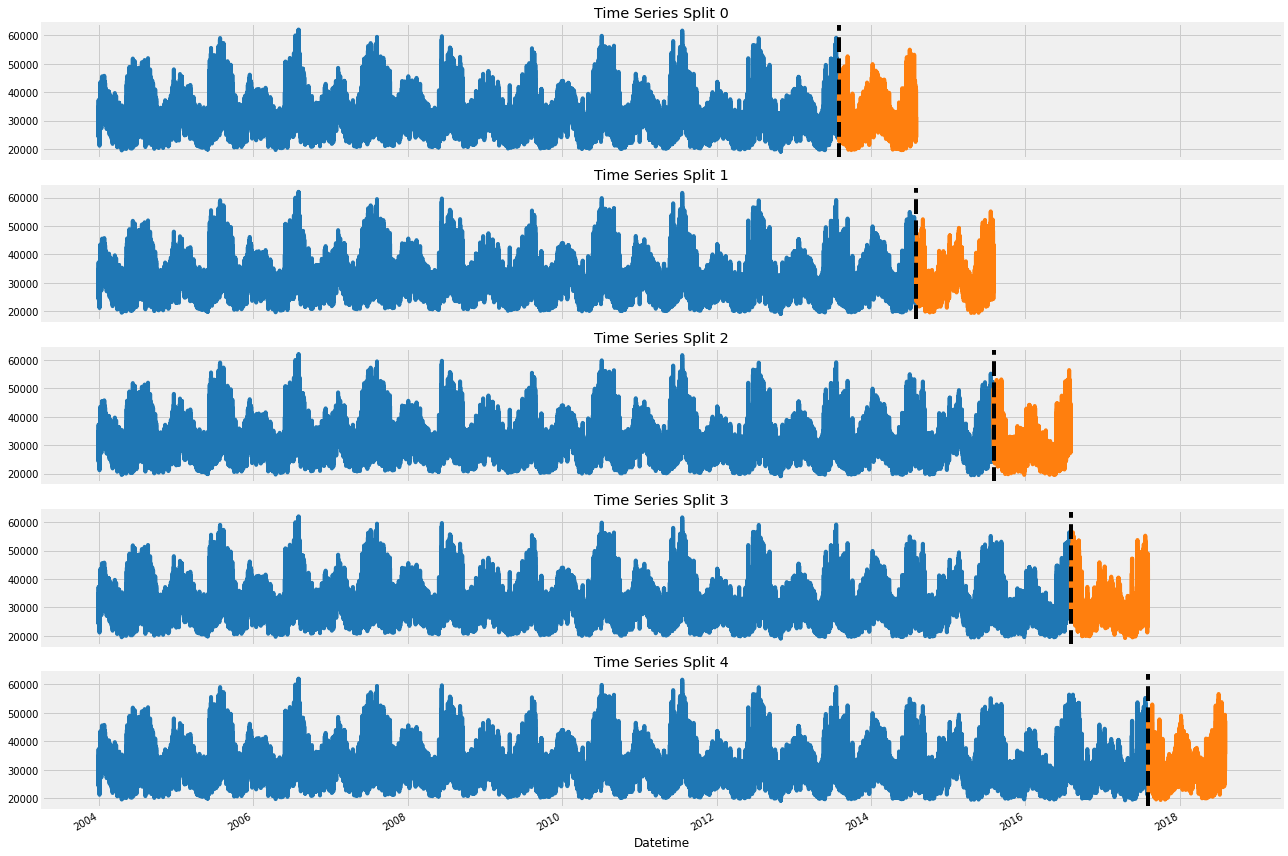

In [201]:
fig, ax = plt.subplots(5,1,figsize=(18,12), sharex=True)
for i, (train_idx, test_idx) in enumerate(tes.split(df),0):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    train['PJME_MW'].plot(style='-', color=color_pal[0], title=f'Time Series Split {i}', ax=ax[i])
    test['PJME_MW'].plot(style='-', color=color_pal[1], title=f'Time Series Split {i}', ax=ax[i])
    ax[i].axvline(train.index.max(), color='k', ls='--')
fig.tight_layout()
plt.show()

In [202]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [204]:
preds=[]
scores=[]
for train_idx, test_idx in tes.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    X_train = train.drop('PJME_MW', axis=1)
    y_train = train.PJME_MW
    X_test = test.drop('PJME_MW', axis=1)
    y_test = test.PJME_MW
    
    reg = xgb.XGBRegressor(base_score=0.5, n_estimators=500, early_stopping_rounds=50,
                           objective='reg:linear', max_depth=5, learning_rate=0.01)
    
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train),(X_test, y_test)],
            verbose = 100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test,y_pred))
    scores.append(score)

[17:10:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32902.93359	validation_1-rmse:31995.10156


/Users/mingtsung/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12438.03809	validation_1-rmse:12105.04297
[200]	validation_0-rmse:5411.12549	validation_1-rmse:5502.73389
[300]	validation_0-rmse:3421.99756	validation_1-rmse:3841.21997
[400]	validation_0-rmse:2982.93457	validation_1-rmse:3568.60693
[499]	validation_0-rmse:2856.22217	validation_1-rmse:3503.16260
[17:10:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:39] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue i

/Users/mingtsung/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12413.73047	validation_1-rmse:12217.55371
[200]	validation_0-rmse:5418.65039	validation_1-rmse:5500.76562
[300]	validation_0-rmse:3448.44678	validation_1-rmse:3705.53857
[400]	validation_0-rmse:3016.47485	validation_1-rmse:3368.51196
[499]	validation_0-rmse:2903.24512	validation_1-rmse:3308.03906
[17:10:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:10:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue i

/Users/mingtsung/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12394.70508	validation_1-rmse:11494.69727
[200]	validation_0-rmse:5418.56299	validation_1-rmse:4996.74512
[300]	validation_0-rmse:3460.71216	validation_1-rmse:3419.90430
[400]	validation_0-rmse:3038.01636	validation_1-rmse:3209.65454
[499]	validation_0-rmse:2922.12866	validation_1-rmse:3214.89233
[17:11:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:10] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue i

/Users/mingtsung/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12349.26758	validation_1-rmse:12028.99316
[200]	validation_0-rmse:5403.78223	validation_1-rmse:5647.08447
[300]	validation_0-rmse:3461.59863	validation_1-rmse:4098.45361
[400]	validation_0-rmse:3042.13159	validation_1-rmse:3847.99292
[499]	validation_0-rmse:2929.98267	validation_1-rmse:3817.62378
[17:11:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:11:29] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue i

/Users/mingtsung/opt/miniconda3/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[100]	validation_0-rmse:12330.55176	validation_1-rmse:12065.06348
[200]	validation_0-rmse:5422.77490	validation_1-rmse:5658.74951
[300]	validation_0-rmse:3498.71509	validation_1-rmse:4109.75781
[400]	validation_0-rmse:3087.01733	validation_1-rmse:3845.50513
[499]	validation_0-rmse:2974.63184	validation_1-rmse:3804.23999


In [205]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores: {scores}')

Score across folds 3529.5916
Fold scores: [3503.1625611045356, 3308.0392132413763, 3214.892634222425, 3817.623706823198, 3804.2399244380254]


In [206]:
X_all = df.drop('PJME_MW', axis=1)
y_all = df.PJME_MW

In [209]:
reg = xgb.XGBRegressor(base_score=0.5, n_estimators=1000, early_stopping_rounds=50,
                        objective='reg:linear', max_depth=5, learning_rate=0.01)
    
reg.fit(X_all, y_all,
            eval_set=[(X_all, y_all)],
            verbose = 100)

[17:12:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[17:12:54] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_eek2t0c4ro/croots/recipe/xgboost-split_1659548960591/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[0]	validation_0-rmse:32475.44336
[100]	validation_0-rmse:12313.02441
[200]	validation_0-rmse:5435.51611
[300]	validation_0-rmse:3536.27466
[400]	validation_0-rmse:3132.06299
[500]	validation_0-rmse:3024.31616
[600]	validation_0-rmse:2955.45898
[700]	validation_0-rmse:2901.47998
[800]	validat

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, early_stopping_rounds=50,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=8,
             num_parallel_tree=1, objective='reg:linear', predictor='auto',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [218]:
#Create date
future = pd.date_range('2018-08-03','2018-08-09', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_future = pd.concat([df, future_df])

In [220]:
map_dict_future = df_future['PJME_MW'].to_dict()
df_future['lag_year1'] = (df_future.index - pd.Timedelta('364 days')).map(map_dict_future)
df_future['lag_year2'] = (df_future.index - pd.Timedelta('728 days')).map(map_dict_future)
df_future['lag_week1'] = (df_future.index - pd.Timedelta('7 days')).map(map_dict_future)
df_future['lag_week2'] = (df_future.index - pd.Timedelta('14 days')).map(map_dict_future)
df_future['lag_week3'] = (df_future.index - pd.Timedelta('21 days')).map(map_dict_future)
df_future['lag_week4'] = (df_future.index - pd.Timedelta('28 days')).map(map_dict_future)

In [221]:
df_future.tail()

,PJME_MW,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,lag_year1,lag_year2,lag_week1,lag_week2,lag_week3,lag_week4,isFuture
2018-08-08 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39283.0,49820.0,46912.0,40182.0,42401.0,44899.0,True
2018-08-08 21:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38245.0,49110.0,45985.0,39434.0,40363.0,43176.0,True
2018-08-08 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36424.0,46930.0,44094.0,38033.0,38647.0,41557.0,True
2018-08-08 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33222.0,43409.0,40666.0,35368.0,35276.0,38176.0,True
2018-08-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30096.0,39942.0,37158.0,32551.0,31896.0,34724.0,True


In [222]:
df_future = df_future[df_future['isFuture'] == True].copy()

In [223]:
df_future.head()

,PJME_MW,hour,dayofweek,month,year,dayofyear,dayofmonth,weekofyear,lag_year1,lag_year2,lag_week1,lag_week2,lag_week3,lag_week4,isFuture
2018-08-03 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33539.0,32094.0,35742.0,31740.0,32887.0,40087.0,True
2018-08-03 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30781.0,29503.0,32798.0,29098.0,30004.0,37168.0,True
2018-08-03 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29015.0,27712.0,30772.0,27369.0,28104.0,35164.0,True
2018-08-03 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27884.0,26535.0,29279.0,26175.0,26823.0,33844.0,True
2018-08-03 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27223.0,25870.0,28422.0,25451.0,26097.0,33133.0,True


In [224]:
df_future['pred'] = reg.predict(df_future.drop(['PJME_MW','isFuture'],axis=1))

<AxesSubplot:title={'center':'Future Prediction'}>

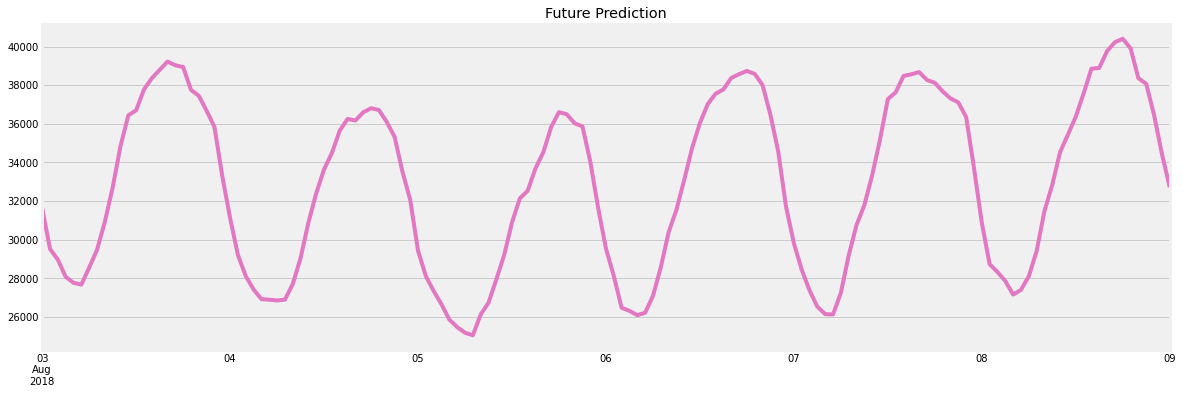

In [225]:
df_future['pred'].plot(style='-', figsize=(18,6), color=color_pal[6], title='Future Prediction')